# Collaborative Filtering Recommender System - Movielens dataset

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import warnings


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score


from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import implicit

In [2]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('../data/movielens/u.data', sep='\t', names=columns)
df.shape

(100000, 4)

### Read train and test data

In [3]:
r_cols = ['user_id', 'item_id', 'rating', 'timestamp']
train = pd.read_csv('../data/movielens/ua.base', sep='\t', names=r_cols, encoding='latin-1')
test = pd.read_csv('../data/movielens/ua.test', sep='\t', names=r_cols, encoding='latin-1')
#train_data, test_data = train_test_split(df, test_size=0.25)

train.shape, test.shape

((90570, 4), (9430, 4))

In [4]:
movie_titles = pd.read_csv("../data/movielens/Movie_Id_Titles")
movie_titles.head(n=2)

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


In [5]:
# Merge 2 dataet together
df = pd.merge(df,movie_titles,on='item_id')
train = pd.merge(train,movie_titles,on='item_id')
test = pd.merge(test,movie_titles,on='item_id')
train.head()

,user_id,item_id,rating,timestamp,title
0,1,1,5,874965758,Toy Story (1995)
1,2,1,4,888550871,Toy Story (1995)
2,6,1,4,883599478,Toy Story (1995)
3,10,1,4,877888877,Toy Story (1995)
4,13,1,3,882140487,Toy Story (1995)


# Exploratory Data Analysis (EDA)

In [6]:
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [7]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [8]:
ratings['number_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,number_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


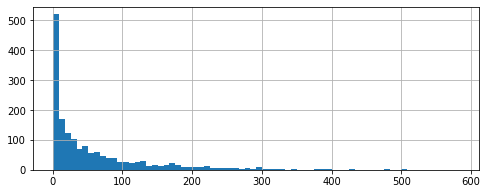

In [9]:
#We can see from the below figure that most of the movies have few number of ratings.
plt.figure(figsize=(8,3))
ratings['number_ratings'].hist(bins=70)

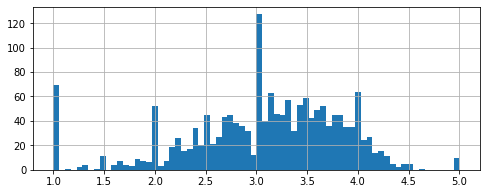

In [10]:
# This histogram shows the distribution of rating 
plt.figure(figsize=(8,3))
ratings['rating'].hist(bins=70)

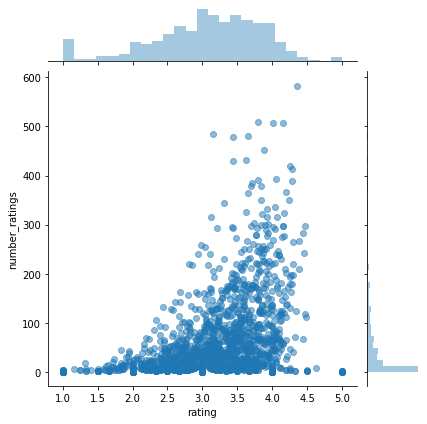

In [11]:
# More rating highest number of rating
sns.jointplot(x='rating',y='number_ratings',data=ratings,alpha=0.5)
plt.show()

# Find Similar Movies

In [12]:
movie_matrix = df.pivot_table(index='user_id',columns='title',values='rating')

In [13]:
movie_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [14]:
def find_similar_movies(movie_name):
    #Select user ratings for two movies 
    movie_user_ratings = movie_matrix[movie_name]

    # Find correlations between series with corrwith (instead of corr)
    similar_to_movie = movie_matrix.corrwith(movie_user_ratings)

    # Removing NaN values and using a DataFrame instead of a series 
    corr_movies = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    corr_movies.dropna(inplace=True)

    corr_movies = corr_movies.join(ratings['number_ratings'])

    result = corr_movies[corr_movies['number_ratings']>100].sort_values('Correlation',ascending=False).head()
    return result

In [15]:
warnings.filterwarnings("ignore")
find_similar_movies('Die Hard (1988)')

,Correlation,number_ratings
title,,
Die Hard (1988),1.000000,243
Die Hard: With a Vengeance (1995),0.577216,151
Die Hard 2 (1990),0.510473,166
Absolute Power (1997),0.477706,127
Nikita (La Femme Nikita) (1990),0.444070,127


# Recommendation Engine - collaborative filtering model from scratch

## Memory-Based CF by computing cosine similarity

In [16]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users,n_items

(943, 1682)

In [17]:
# create a user-item matrix which can be used to calculate the similarity between users and items

data_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

# because of splitting the data into test and train we need to create two [943 x 1682] matrices

train_data_matrix = np.zeros((n_users, n_items))
# unpack the Pandas object
for line in train.itertuples():
    # adjust to count rows and cols from 0 and fill in the matrix
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [18]:
data_matrix.shape

(943, 1682)

In [19]:
train_data_matrix.shape, test_data_matrix.shape

((943, 1682), (943, 1682))

In [20]:
# calculating the similarity by using the pairwise_distance from sklearn to calculate the cosine similarity
from sklearn.metrics.pairwise import pairwise_distances 

# user-user similarity
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')

# item-item similarity
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

user_similarity.shape , item_similarity.shape

((943, 943), (1682, 1682))

we can make a prediction by applying the following formula for user-based CF.


1) We can look at the similarity between users k and a as weights

2)  weights are multiplied by the ratings of a similar user a (corrected for the average rating of that user)

3) We need to normalize it so that the ratings stay between 1 and 5

4) As a final step, sum the average ratings for the user that you are trying to predict.

$$\hat{x}_{k,m}= \bar{x}_{k} + \frac{\sum_{u_{a}}sim_{u}(u_{k},u_{a})(x_{a,m}-\bar{x}_{u_{a}})}
{\sum_{u_{a}\left | sim_{u}(u_{k},u_{a}) \right |}}
$$

Also, we can make a prediction by applying the following formula for item-based CF.

 $$\hat{x}_{k,m}=  \frac{\sum_{i_{b}}sim_{i}(i_{m},i_{b})(x_{k,b})}
{\sum_{i_{b}\left | sim_{i}(i_{m},i_{b}) \right |}}
$$

In [21]:
#make predictions based on these similarities

def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [22]:
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

user_prediction.shape,item_prediction.shape

((943, 1682), (943, 1682))

## Model-Based CF by using singular value decomposition (SVD)

$$X = USV^{T}$$



In [23]:
sparsity = round(1.0-len(df)/float(n_users*n_items), 3)
print('The sparsity level of MovieLens100K is ' + str(sparsity*100) + '%')


import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k=20)
s_diag_matrix=np.diag(s)

#prediction
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

The sparsity level of MovieLens100K is 93.7%


## Using Alternating Least Squares (ALS) to Fit Model

In [24]:
#We need to turn the pandas dataframe into a numpy array in order to create the sparse matrix
ratings = df.as_matrix(['user_id', 'item_id', 'rating'])
ratings[:,0] -= 1
ratings[:,1] -= 1
ratings, ratings.shape

(array([[ 195,  241,    3],
        [  62,  241,    3],
        [ 225,  241,    5],
        ...,
        [ 654, 1636,    3],
        [ 654, 1629,    3],
        [ 654, 1640,    3]]), (100000, 3))

In [25]:
#split the ratings array into training and testing data
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.10)

In [26]:
#Creating the Sparse Matrix
# This matrix should be a csr_matrix where the rows of the matrix are the item
#the columns are the users that liked that item, and the value is the confidence that the user liked the item.

user_tr, movie_tr, rating_tr = zip(*ratings_train)
sparse_tr = csr_matrix((rating_tr, (user_tr, movie_tr)), shape = (n_users, n_items))

user_ts, movie_ts, rating_ts = zip(*ratings_test)
sparse_ts = csr_matrix((rating_ts, (user_ts, movie_ts)), shape = (n_users, n_items))

sparse_tr.shape, sparse_ts.shape

((943, 1682), (943, 1682))

In [27]:
model = implicit.als.AlternatingLeastSquares(factors = 50,
                                            regularization = 0.1,
                                            iterations = 150,
                                            calculate_training_loss = True)
#A regularization term is used as a parameter to avoid overfitting

In [28]:
model.fit(sparse_tr)

In [29]:
#Array of latent factors for each user in the training set
user_vecs = model.user_factors

#Array of latent factors for each item in the training set
item_vecs = model.item_factors

In [30]:
def predict(user_vecs, item_vecs):
    preds = []
    i = 0
    for i in range(n_users):
            pred = np.dot(user_vecs[i], item_vecs[i])
            preds.append(pred)
            i += 1
    return sum(preds) / len(preds)
predict(user_vecs, item_vecs)

0.1369242281652987

In [31]:
#Get Recommendations
user_id =   14
recommended = model.recommend(user_id, sparse_ts)
print(recommended)

[(12, 1.4770511), (592, 1.349575), (94, 1.3062918), (400, 1.2882057), (918, 1.2472426), (532, 1.2425023), (763, 1.2417653), (64, 1.231122), (273, 1.2305318), (681, 1.2295126)]


In [32]:
#Get similar items for Die Hard (1988)
item_id = 144
n_similar = 3
similar = model.similar_items(item_id, n_similar)
print(similar)

[(144, 1.4465086), (269, 0.7876135), (547, 0.77316123)]


## Evaluation with RMSE and MAE

In [33]:
def rmse(prediction, y):
    prediction = prediction[y.nonzero()].flatten()
    y = y[y.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, y))

def mae(prediction, y):
    prediction = prediction[y.nonzero()].flatten()
    y = y[y.nonzero()].flatten()
    return sqrt(mean_absolute_error(prediction, y))

print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))
print('Model-Based CF RMSE: ' + str(rmse(X_pred, test_data_matrix)))
print("\n")
print('User-based CF MAE: ' + str(mae(user_prediction, test_data_matrix)))
print('Item-based CF MAE: ' + str(mae(item_prediction, test_data_matrix)))
print('Model-Based CF MAE: ' + str(mae(X_pred, test_data_matrix)))

User-based CF RMSE: 3.1801799301154703
Item-based CF RMSE: 3.6039427909848873
Model-Based CF RMSE: 2.8258075694458307


User-based CF MAE: 1.7252144402114702
Item-based CF MAE: 1.849034489369964
Model-Based CF MAE: 1.5957847598859092


## Evaluation with Precision and recall
Precision and recall are binary metrics used to evaluate models with binary output. 

We need a way to translate the ratings from 1 to 5 into a binary problem.

To do the translation we will assume that any true rating above 3.5 corresponds to a relevant item and any true rating below 3.5 is irrelevant. 

We are intrested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items.

Thus the notion of precision and recall at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

In [34]:
# threshold = 3.5


# Fast AI

In [35]:
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [36]:
# import collaborative filtering package
from fastai.collab import *

In [37]:
# Turn the title columns in category codes(to replace them with their codes for an Embedding layer)
# size of our validation set = 0.1
# we can add rating_name and user_name too.

data = CollabDataBunch.from_df(df, seed=42, valid_pct=0.1, 
                                      user_name='user_id', item_name='title', rating_name='rating')

In [38]:
#show a random batch of our data
data.show_batch()

user_id,title,target
796,"Client, The (1994)",4.0
545,Space Jam (1996),3.0
234,Of Human Bondage (1934),4.0
290,Top Gun (1986),4.0
709,Escape from New York (1981),3.0


In [39]:
#getting the max and min values of our ratings
df.rating.min(), df.rating.max()

(1, 5)

## EmbeddingDotBias

In [40]:
# creat Learner object (our model)
# n_factors represents the size of the embedding vectors

#EmbeddingDotBias
learn = collab_learner(data, n_factors=40, y_range=(1,5), wd=1e-1)


#EmbeddingNN Model
#learn = collab_learner(data, n_factors=40, y_range=(1,5), use_nn=True, layers=[256, 128])

In [41]:
print(learn.model)

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


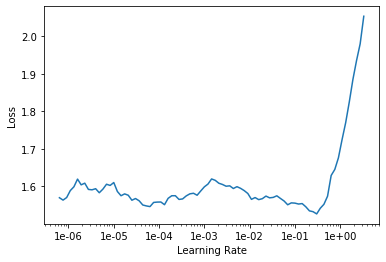

In [42]:
# find the perfect learning rates we can use the lr_find 
learn.lr_find()
# plot learning rate graph
learn.recorder.plot()

In [43]:
# Train our model using the fit_one_cycle method
learn.fit_one_cycle(4, 1e-02)

epoch,train_loss,valid_loss,time
0,0.920956,0.949172,00:11
1,0.855804,0.877038,00:12
2,0.751922,0.832972,00:11
3,0.600572,0.823892,00:12


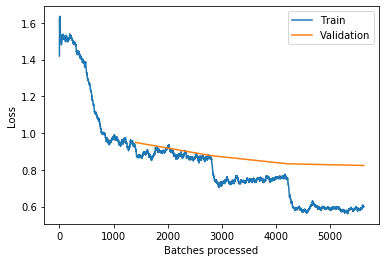

In [44]:
learn.recorder.plot_losses()

In [45]:
learn.save('movie-dot-1')

In [46]:
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [47]:
learn = learn.load('movie-dot-1')

In [48]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid)

In [49]:
preds

tensor([3.5005, 3.1774, 3.9184,  ..., 3.8283, 2.9655, 4.1761])

In [50]:
y, y.shape

(tensor([3., 5., 4.,  ..., 4., 3., 4.]), torch.Size([10000]))

In [51]:
print('Fastai CF RMSE: ' + str(rmse(preds, y)))
print('Fastai CF MAE: ' + str(mae(preds, y)))

Fastai CF RMSE: tensor(0.9077)
Fastai CF MAE: tensor(0.7204)


### Recommend movie for a user

In [52]:
rows = []
movies = list(df.drop_duplicates(subset='item_id', keep='first').item_id)
names = list(df.drop_duplicates(subset='item_id', keep='first').title)

for i in range(len(movies)):
    rows.append( dict({'name': names[i], 'item_id' : movies[i], 'user_id' : 9}))
test_data = pd.DataFrame(rows)

In [53]:
for idx, (score, name) in enumerate(sorted(zip(preds, names), reverse=True)):
    if idx >= 10:
        break
    print("Score: ", round(float(score), 2), " for movie: ", name)

Score:  4.84  for movie:  Boys on the Side (1995)
Score:  4.82  for movie:  Beauty and the Beast (1991)
Score:  4.78  for movie:  Hamlet (1996)
Score:  4.76  for movie:  Home Alone (1990)
Score:  4.76  for movie:  French Kiss (1995)
Score:  4.76  for movie:  Denise Calls Up (1995)
Score:  4.75  for movie:  Nénette et Boni (1996)
Score:  4.74  for movie:  Maya Lin: A Strong Clear Vision (1994)
Score:  4.71  for movie:  My Best Friend's Wedding (1997)
Score:  4.7  for movie:  Tigrero: A Film That Was Never Made (1994)


# Resources

https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c

https://course.fast.ai/videos/?lesson=4

https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00

https://medium.com/quantyca/deep-learning-for-collaborative-filtering-using-fastai-b28e197ccd59

https://github.com/dgrubis/Movie-Recommendations/blob/master/Movie%20Recommendation%20System.ipynb